In [1]:
import numpy as np

class BernoulliBandit :
    def __init__(self, K) :
        self.probs = np.random.uniform(size=K)
        self.K = K
        self.best_idx = np.argmax(self.probs)
        self.best_prob = self.probs[self.best_idx]
        
    def step(self, k:int) :
        if np.random.rand() < self.probs[k] :
            return 1
        return 0
    def status(self) :
        print(self.probs, self.K, self.best_prob, self.best_idx)

bb = BernoulliBandit(10)
reward = bb.step(int(2))
print(reward)
bb.status()

1
[0.48123249 0.47888243 0.84503709 0.80592134 0.70832998 0.93985084
 0.18472218 0.82410122 0.34853732 0.69438075] 10 0.939850841670939 5


In [2]:
class Solver :
    def __init__(self, bandit) :
        self.bandit = bandit
        self.counter = [0 for i in range(bandit.K)]
        self.regrets = [] #[0 for i in range(bandit.K)] 是懊悔记录，不是每个臂的懊悔，别跟reward混淆
        self.regret = 0
    def run_one_step(self) :
        # choose one bandit and return
        return np.random.randint(0, self.bandit.K)

    def update_regret(self, k) :
        # 每次的懊悔累积,记录下来。相当于是懊悔的定积分。
        self.regret += self.bandit.best_prob - self.bandit.probs[k] 
        self.regrets.append(self.regret)
    
    def run(self, max_step) :
        for i in range(max_step) :
            k = self.run_one_step()
            self.counter[k] += 1
            self.update_regret(k)
    def until_cond(self) :
        return False
    def run_until(self, max_step) :
        for i in range(max_step) :
            if self.until_cond() :
                return i
            k = self.run_one_step()
            self.counter[k] += 1
            self.update_regret(k)
        return max_step
    
    def status(self) :
        print("counter:", self.counter)
        print("regrets:", self.regrets)
s = Solver(bb)
s.run(10)
s.run_until(10)
s.status()

counter: [1, 2, 3, 2, 0, 2, 3, 0, 3, 4]
regrets: [0.5913135224090866, 0.6861272756737226, 0.9315973645625383, 1.1770674534513539, 1.4225375423401696, 1.4225375423401696, 1.6680076312289853, 2.4231362918851582, 3.178264952541331, 3.273078705805967, 3.40700820344437, 3.8679766147308943, 3.8679766147308943, 4.326594963303827, 4.421408716568463, 5.176537377224635, 5.767850899633721, 6.228819310920246, 6.820132833329332, 6.954062330967735]


In [3]:
class EpsilonGreedy(Solver) :
    def __init__(self, bandit, epsilon=0.01) :
        super().__init__(bandit)
        self.epsilon = epsilon
        self.estimates = [1.0 for i in range(0, self.bandit.K)]

    def run_one_step(self) :
        if np.random.rand() < self.epsilon :
            k = np.random.randint(0, self.bandit.K)
        else :
            k = np.argmax(self.estimates)
        r = self.bandit.step(k)
        self.counter[k] += 1
        self.estimates[k] += ((r - self.estimates[k]) / (self.counter[k] + 1))
        return k

这里estimates初始化值设置成1有讲究。  
这叫乐观初始值，理论上应该设置为比最大reward更大的值。这里reward返回0和1，所以设置成1.  
这会影响贪婪行动（np.random.rand() > self.epsilon）时的选择。  
想象最开始所有动作估计都初始化成最大值。这时候选了一个动作，计算出来的估计必然小于0，更小于其他动作的初始值。  
这会导致下一次再进行贪婪行动的时候，选择那些还未尝试过的动作。

In [4]:
import matplotlib.pyplot as plt

def plot_results(solvers, solver_names):
    """生成累积懊悔随时间变化的图像。输入solvers是一个列表,列表中的每个元素是一种特定的策略。
    而solver_names也是一个列表,存储每个策略的名称"""
    for idx, solver in enumerate(solvers):
        time_list = range(len(solver.regrets))
        plt.plot(time_list, solver.regrets, label=solver_names[idx])
    plt.xlabel('Time steps')
    plt.ylabel('Cumulative regrets')
    plt.title('%d-armed bandit' % solvers[0].bandit.K)
    plt.legend()
    plt.show()

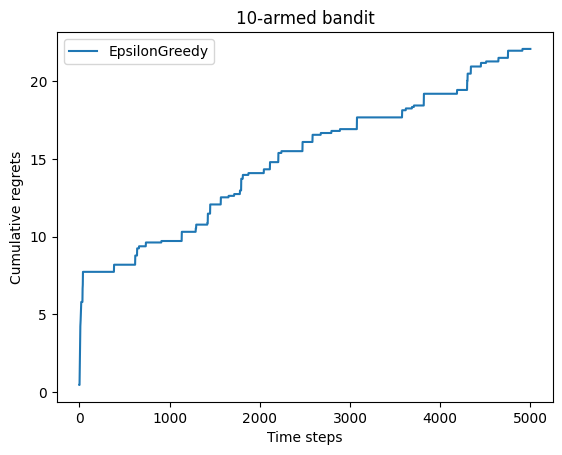

In [5]:
np.random.seed(1)
eg = EpsilonGreedy(bb, 0.01)
eg.run(5000)
plot_results([eg], ['EpsilonGreedy'])

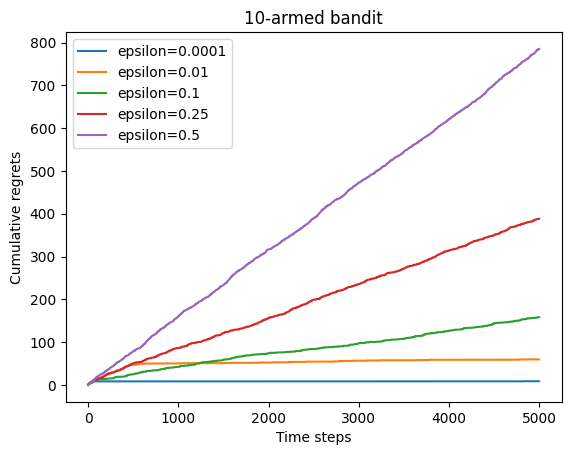

In [6]:
epsilons = [1e-4, 0.01, 0.1, 0.25, 0.5]
epsilon_greedy_solver_list = [
    EpsilonGreedy(bb, epsilon=e) for e in epsilons
]
epsilon_greedy_solver_names = ["epsilon={}".format(e) for e in epsilons]
for solver in epsilon_greedy_solver_list:
    solver.run(5000)

plot_results(epsilon_greedy_solver_list, epsilon_greedy_solver_names)

懊悔是个评估指标，相当于监督学习里的label。实际任务中不可能提前知道哪个是最优的策略。  
epsilon越大，随机性越强，越难选到最优策略，懊悔也就越大。  
epsilon设为0，贪婪策略，几轮就能找到最优策略，懊悔不再增长了。

In [7]:
class DecaylingEpsilonGreedy(Solver) :
    def __init__(self, bandit) :
        super().__init__(bandit)
        self.estimates = [1.0 for i in range(0, self.bandit.K)]
        self.total_count = 1

    def run_one_step(self) :
        self.total_count += 1
        if np.random.rand() < 1 / self.total_count :
            k = np.random.randint(0, self.bandit.K)
        else :
            k = np.argmax(self.estimates)
        r = self.bandit.step(k)
        self.counter[k] += 1
        self.estimates[k] += ((r - self.estimates[k]) / (self.counter[k] + 1))
        return k

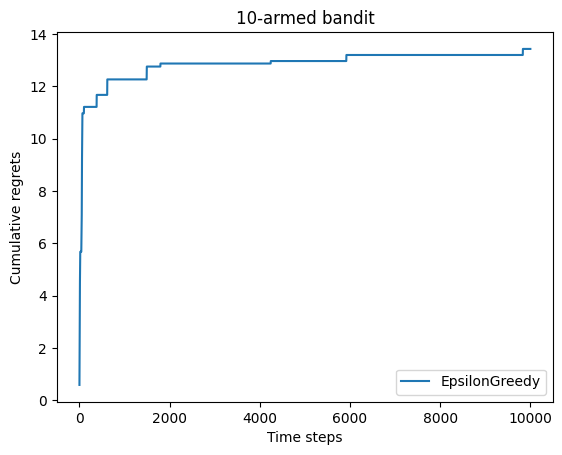

In [8]:
np.random.seed(1)
eg = DecaylingEpsilonGreedy(bb)
eg.run(10000)
plot_results([eg], ['EpsilonGreedy'])

到这我有一个疑问：  
既然每台老虎机的概率分布是固定的，不会随着策略变化而变化，那为什么不这么解：  
每台老虎机试x次，计算奖励均值以估计期望，后边选期望最大的那台老虎机即可。  
LLM说：
1. 探索效率低。这个有可能，x设置到多少合适，一共需要试验x * K次，才得出结果。而且按照大数定律，x越大越准。
2. 无法应对动态变化。这有点扯淡了，推翻了基本假设。当然探索性算法的动态探索能力肯定更强。
3. 理论性能差距，也就是累计懊悔，它认为我的方法会越来越大。我不太信，我觉得试x次之后我就找到了最佳答案，懊悔降为0.
我也写个代码比较下。
1. 调整x，看看多少次懊悔才能降到0.

In [12]:
class JustTryIt(Solver) :
    def __init__(self, bandit, x=10) :
        super().__init__(bandit)
        self.estimates = [1.0 for i in range(0, self.bandit.K)]
        self.x = x
        self.max_count = 0

    def until_cond(self) :
        if np.argmax(self.estimates) == self.bandit.best_idx :
            self.max_count += 1
        return self.max_count > 10
        
    def run_one_step(self) :
        try_all = True
        for i in range(self.bandit.K) :
            if self.counter[i] < self.x :
                k = i
                try_all = False
                break
        if try_all :
            k = np.argmax(self.estimates)
        r = self.bandit.step(k)
        self.estimates[k] += ((r - self.estimates[k]) / (self.counter[k] + 1))

        return k

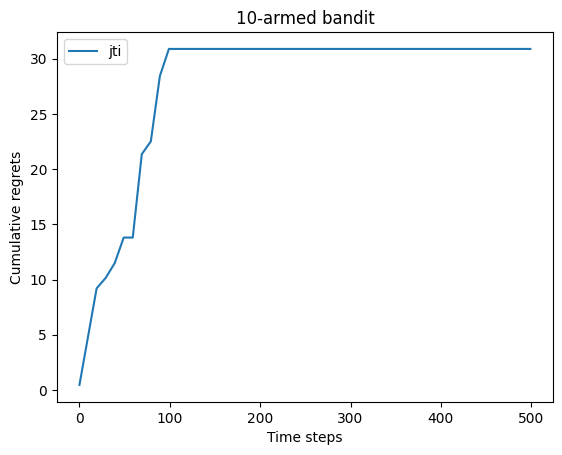

In [10]:
np.random.seed(1)

jti=JustTryIt(bb, x=10)
jti.run(500)

plot_results([jti], ['jti'])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19] [43, 256, 57, 5000, 79, 73, 104, 94, 48, 51, 57, 141, 145, 79, 79, 213, 213, 84, 87]


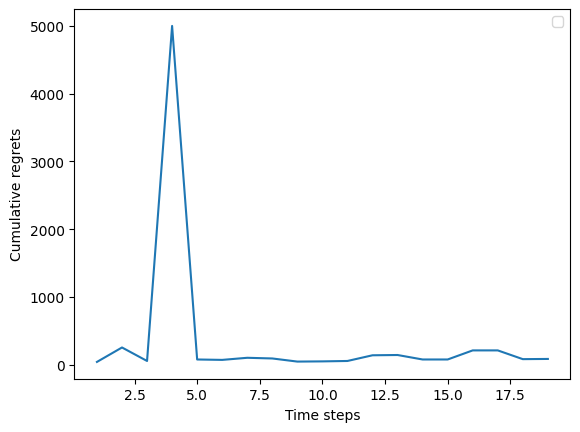

In [13]:

xs = [i for i in range(1,20)]
ys = []
epsilon_greedy_solver_list = [
    JustTryIt(bb, x=x) for x in xs
]
epsilon_greedy_solver_names = ["x={}".format(x) for x in xs]
for solver in epsilon_greedy_solver_list:
    np.random.seed(1)
    ys.append(solver.run_until(5000))
print(xs, ys)

plt.plot(xs, ys, label='')
plt.xlabel('Time steps')
plt.ylabel('Cumulative regrets')
plt.title('')
plt.legend()
plt.show()

100次累积懊悔就不再增长了。